In [1]:
from datasets import load_dataset
import openai
from openai import OpenAI
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import os 

/Users/joaodias/miniforge3/envs/ccu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
openai.api_key = os.getenv("LAB_OPENAI_API_KEY")

In [2]:
ds = load_dataset("roneneldan/TinyStories")
tiny_train = ds['train']
tiny_val = ds['validation']

## Testing coherence models

Rouge-L


In [4]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [5]:
scores['rougeL']

Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)

J-coherence

In [79]:
from sgnlp.models.coherence_momentum import CoherenceMomentumModel, CoherenceMomentumConfig, \
    CoherenceMomentumPreprocessor

# Load Model
config = CoherenceMomentumConfig.from_pretrained(
    "https://storage.googleapis.com/sgnlp-models/models/coherence_momentum/config.json"
)
model = CoherenceMomentumModel.from_pretrained(
    "https://storage.googleapis.com/sgnlp-models/models/coherence_momentum/pytorch_model.bin",
    config=config
)

preprocessor = CoherenceMomentumPreprocessor(config.model_size, config.max_len)

2025-03-24 16:37:55.597449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/joaodias/miniforge3/envs/ccu/lib/python3.9/site-packages/transformers/utils/hub.py:527: FutureWarning: Using `from_pretrained` with the url of a file (here https://storage.googleapis.com/sgnlp-models/models/coherence_momentum/config.json) is deprecated and won't be possible anymore in v5 of Transformers. You should host your file on the Hub (hf.co) instead and use the repository ID. Note that this is not compatible with the caching system (your file will be downloaded at each execution) or multiple processes (each process will download the file in a different temporary file).
  warnings.warn(
/Users/joaodias/miniforge3/envs/ccu/lib/python3.9/site-packages/transformers/util

In [ ]:
# Example text inputs
text1 = tiny_train['text'][0]
text2 = tiny_train['text'][1]

text1_tensor = preprocessor([text1])
text2_tensor = preprocessor([text2])

text1_score = model.get_main_score(text1_tensor["tokenized_texts"]).item()
text2_score = model.get_main_score(text2_tensor["tokenized_texts"]).item()

print(text1_score, text2_score)

20.137290954589844 18.757055282592773


CoLA

In [92]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cointegrated/roberta-large-cola-krishna2020")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/roberta-large-cola-krishna2020")

In [ ]:
text = tiny_train['text'][0]

#tokenize input
inputs = tokenizer(text, return_tensors="pt")

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits

torch.nn.functional.softmax(logits, dim=-1)

tensor([[0.9546, 0.0454]])

## Creation of auto-rater

Auto-rating

In [230]:
batch_size = 128 

train_loader = DataLoader(tiny_train['text'][:10000], batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(tiny_val['text'], batch_size=batch_size, shuffle=False)

In [15]:
def get_coherence_score(extract):
    client = OpenAI()
    
    prompt = ("Below is a text extract. Your task is to analyze the extract and assign a coherence score between 0 and 5 inclusive, where:\n\n"
              "0: The text is completely incoherent and lacks any logical connection.\n"
              "1: The text has some minor connections, but overall it is disjointed and hard to follow.\n"
              "2: The text has some coherence, but it is still difficult to understand due to unclear relationships between ideas.\n"
              "3: The text is moderately coherent, with some clear connections between ideas, but may lack depth or clarity.\n"
              "4: The text is highly coherent, with clear and logical connections between ideas, making it easy to follow.\n"
              "5: The text is extremely coherent, with a clear and concise structure, making it effortless to understand.\n\n"
              "You will provide a score ONLY. Do NOT also provide an explanation.\n"
              f"The extract: {extract}\n"
              "After examining the extract, the coherence score between 0 and 5 inclusive is:")
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",  #using gpt-4o-mini to optimize cost
        messages=[
            {"role": "system", "content": "Analyze the coherence of the given text."},
            {"role": "user", "content": prompt}
        ]
    )
    
    return response.choices[0].message.content.strip()

def batch_coherence(batch):
  batch_scores = []
  for text in batch:
      score = get_coherence_score(text)
      batch_scores.append(score)
    
  return batch_scores

In [ ]:
batch_scores = []
for batch in train_loader:
    scores = batch_coherence(batch)
    batch_scores.append(scores)

In [40]:
all_scores = [int(score) for sublist in batch_scores for score in sublist] #unpack list scores

In [42]:
are_ther_zero = any(score == 0 for score in all_scores)
are_there_one = any(score == 1 for score in all_scores)
print(f'Are there any 0s? - {are_ther_zero}')
print(f'Are there any 1s? - {are_there_one}')

Are there any 0s? - False
Are there any 1s? - False


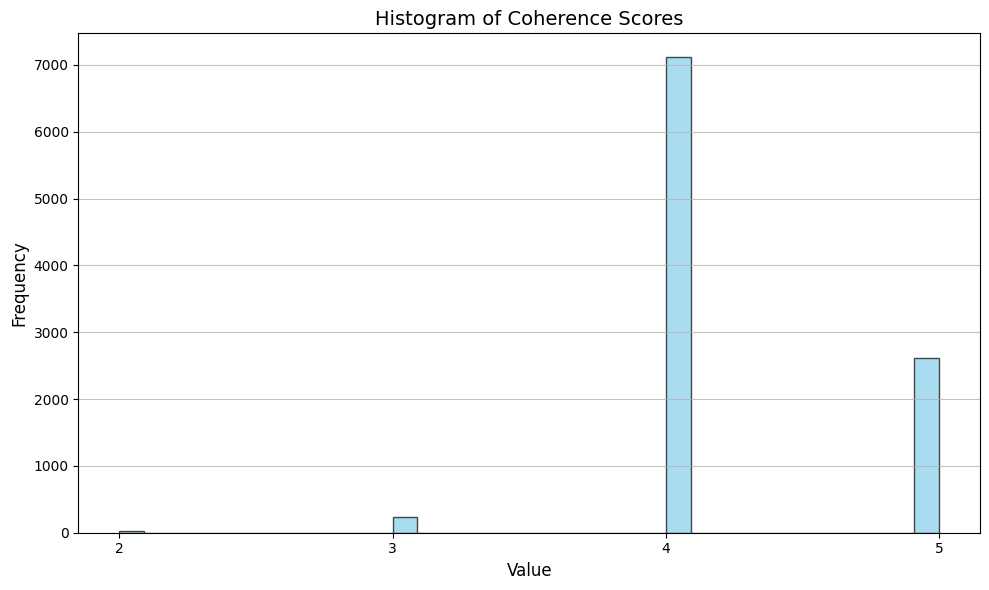

In [53]:
plt.figure(figsize=(10, 6))
plt.hist(all_scores, bins='auto', color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Histogram of Coherence Scores', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.xticks(range(2, 6)) 
plt.ylabel('Frequency', fontsize=12)

plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

save it for later

In [72]:
save_array = np.array(all_scores)

np.save("checkpoints/10000ratings.npy", save_array) 

### Auto-rater shenanigans

Check out incoherent stories

In [65]:
incoherent_stories = np.where(np.array(all_scores) == 2)[0]
for index in incoherent_stories:
    print('\n ew story:')
    print(tiny_train['text'][index])


 New story:
Once upon a time there was an orange needle called Frank. He had been in the same spot for years and he was getting bored. He wanted to explore, but he didn't know how to.

Then one day, a small 3 year old child saw Frank. The child said "Hello Frank! I'm going to help you explore the world." Frank was so excited!

The child said, "I think we should reverse!" Frank looked confused, but the child explained that it meant going backwards, the opposite of forwards.

So, the child and Frank started reversing. They went up and down, side to side and around in circles. Frank was enjoying his adventure!

After an hour of reversing, the child and Frank stopped. The child said, "Wow, that was a lot of fun! You now know that you can explore by reversing."

Frank thanked the child for his help and then said goodbye. As the child walked away, Frank knew that he would never forget this adventure.

 New story:
Ted was a lively little boy. He was always ready for adventure. One day Ted fo

In [82]:
coherent_stories = np.where(np.array(all_scores) == 5)[0]

In [ ]:
text1= tiny_train['text'][incoherent_stories[0]]
text2 = tiny_train['text'][coherent_stories[0]]

text1_tensor = preprocessor([text1])
text2_tensor = preprocessor([text2])

text1_score = model.get_main_score(text1_tensor["tokenized_texts"]).item()
text2_score = model.get_main_score(text2_tensor["tokenized_texts"]).item()

print(text1_score, text2_score)

#### Divide stories into parts - LLM

In [119]:
def divide_story_into_parts(story):

    client = OpenAI()

    response = client.chat.completions.create(
      model="gpt-4o-mini", #lets use mini to optimize cost
      messages=[
        {
          "role": "system",
          "content": """Your job is to divide stories intro three parts:
                      - Introduction: Describe the beginning, including setting or main characters.
                      - Development: Summarize the main events and conflicts.
                      - Conclusion: Provide the ending or resolution.
                      Your output should consist of stating the name of that part,
                      starting and ending the word for the part with ** (ex: **Introduction**), do not use any other tokens/words next to the word for the part.
                      Then copy the content of the story that consists of that part.
                      Do not change the wording."""
        },
        {
          "role": "user",
          "content": story
        }
      ],
    )

    return response.choices[0].message

In [ ]:
random.seed = 3

batch_size = 1000
batch = random.sample(tiny_train['text'], batch_size)

In [123]:
divided_stories = []
for story in batch:
    division = divide_story_into_parts(story)
    divided_stories.append(division.content)

In [131]:
coherence = []
for story in batch:
  coherence.append(get_coherence_score(story))

In [ ]:
with open("checkpoints/1000_divided.txt", "w") as file:
    for story in divided_stories:
        file.write(f"{story}\n")

In [132]:
save_array = np.array(coherence)

np.save("checkpoints/1000ratings.npy", save_array) 

## Load stories from file

In [2]:
def divide_string(text):
    #find the indices of each section
    introduction_start = text.find("**Introduction**")
    development_start = text.find("**Development**")
    conclusion_start = text.find("**Conclusion**")

    #find where the part starts and create it from there until the next part
    introduction_text = text[introduction_start + len("**Introduction**"):development_start].strip()
    development_text = text[development_start + len("**Development**"):conclusion_start].strip()
    conclusion_text = text[conclusion_start + len("**Conclusion**"):].strip()

    return introduction_text, development_text, conclusion_text

In [3]:
with open('checkpoints/1000_divided.txt', "r") as file:
    text = file.read()

#split the file into stories using the **Introduction**
stories = text.split("**Introduction**")
divided_stories = []

for story in stories[1:]:  #skip the first element, its empty before the first **Introduction**
    story = "**Introduction**" + story.strip()
    divided_stories.append(story)

In [4]:
stories = []

for divided in divided_stories:
  introduction, development, conclusion = divide_string(divided)
  stories.append((introduction,development,conclusion))

In [5]:
coherence = np.load("checkpoints/1000ratings.npy")
coherence = coherence.tolist()

## Testing auto-rater 

In [8]:
story_info = []
for story, rating in zip(stories,coherence):
    story_info.append((story, rating))

In [9]:
def imposter_input(story, position, imposter):
    intro, dev, conc= story

    if position == 'intro':
        return imposter + dev + conc
    elif position == 'development':
        return intro + imposter + conc
    elif position == 'conclusion':
        return intro + dev + imposter
    else:
        raise ValueError("Invalid string value for 'position'.")

In [ ]:
def tamper_stories(stories, positions, nr_corruptions):
    indices_to_corrupt = random.sample(range(len(stories)), nr_corruptions)
    
    #obtain indices to tamper with
    shuffled_indices = indices_to_corrupt[:]
    random.shuffle(shuffled_indices)

    #if any two consecutive indices are the same, shuffle again
    while any(i == j for i, j in zip(indices_to_corrupt, shuffled_indices)):
        random.shuffle(shuffled_indices)

    corrupted_stories = []
    tamper_log = {}
    possible_positions = ['intro', 'development', 'conclusion']

    for original, imposter in zip(indices_to_corrupt, shuffled_indices):
        position = random.choice(positions)  #randomly choose which part to corrupt
        imposter_text = stories[imposter][0][possible_positions.index(position)]  #get the imposter part
        corrupted_stories.append(imposter_input(stories[original][0], position, imposter_text))
        og_rate = stories[original][1]
        imp_rate = stories[imposter][1]

        tamper_log[original] = {
        "tampered_by": imposter,
        "position": position,
        "origina_rating": og_rate,
        "imposter_rating": imp_rate
        }   

    return corrupted_stories, tamper_log

In [10]:
def separate_ratings(story_info):
    index_0 = []
    index_1 = []
    index_2 = []
    index_3 = []
    index_4 = []
    index_5 = []
    for i,story in enumerate(story_info):
        rating = story[1]
        if rating == '0':
            index_0.append(i)
        elif rating == '1':
            index_1.append(i)   
        elif rating == '2':
            index_2.append(i)
        elif rating == '3':
            index_3.append(i)
        elif rating == '4':
            index_4.append(i)
        elif rating == '5':
            index_5.append(i)
    return (index_0,index_1,index_2,index_3,index_4,index_5)

idx = separate_ratings(story_info)

In [ ]:
def tamper_storiesV2(stories_info, idx, positions,nr_corruptions):
    random.seed(10)
    possible_positions = ['intro', 'development', 'conclusion']
  
    indices_to_corrupt = random.sample(range(len(stories_info)), nr_corruptions)
    shuffled_indices = indices_to_corrupt[:]
    random.shuffle(shuffled_indices)
    selected_stories = [stories_info[i] for i in shuffled_indices]
    
    corrupted_stories = []
    tamper_log = {}
    for i, story_info in enumerate(selected_stories):
        story = story_info[0]
        rating = int(story_info[1])
        if rating == 2:
            possible_idx_flatten = idx[2] #if rating is 2 just swithc w/ another 2
        else:
            possible_idx = idx[2:rating] #assuming lowest rating is 2
            possible_idx_flatten = [idx 
                                for item in possible_idx 
                                for idx in item]
        
        imposter_idx = random.choice(possible_idx_flatten)
        position = random.choice(positions)
        imposter_text = stories_info[imposter_idx][0][possible_positions.index(position)]
        imposter_rating = stories_info[imposter_idx][1]
        corrupted_story = imposter_input(story, position, imposter_text)
        corrupted_stories.append(corrupted_story)

        tamper_log[shuffled_indices[i]] = {
        "tampered_by": imposter_idx,
        "position": position,
        "origina_rating": rating,
        "imposter_rating": imposter_rating
        }   
    return corrupted_stories,tamper_log

In [221]:
corrupted_stories, log = tamper_stories(story_info, positions=['conclusion'], nr_corruptions=500)

In [13]:
corrupted_stories, log = tamper_storiesV2(story_info, idx, positions=['conclusion'], nr_corruptions=500)

#### Re-rate inputed stories

In [16]:
new_coherence = []
for story in corrupted_stories:
  new_coherence.append(get_coherence_score(story))

In [19]:
new_coherence_array = np.array(new_coherence)

np.save("checkpoints/10000ratings_retate.npy", new_coherence_array) 

#### See changes in ratings

In [ ]:
# Extract old and new ratings
affected_indices = list(log.keys())
old_ratings = [log[story]["origina_rating"] for story in affected_indices]
imposter_rating = [log[story]["imposter_rating"] for story in affected_indices]
new_ratings = new_coherence

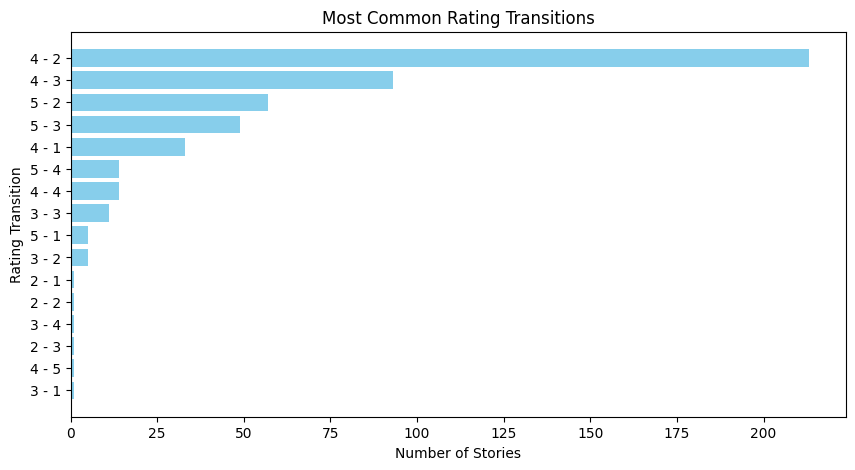

In [ ]:
from collections import Counter
# Count frequency of each rating transition (e.g., "3 → 5")
transitions = [f"{old} - {new}" for old, new in zip(old_ratings, new_ratings)]
transition_counts = Counter(transitions)

# Sort transitions by frequency
sorted_transitions = sorted(transition_counts.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
labels, values = zip(*sorted_transitions)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(labels, values, color="skyblue")
plt.xlabel("Number of Stories")
plt.ylabel("Rating Transition")
plt.title("Most Common Rating Transitions")
plt.gca().invert_yaxis()  # Highest frequency on top
plt.show()

In [30]:
sorted_transitions

[('4 - 2', 213),
 ('4 - 3', 93),
 ('5 - 2', 57),
 ('5 - 3', 49),
 ('4 - 1', 33),
 ('5 - 4', 14),
 ('4 - 4', 14),
 ('3 - 3', 11),
 ('5 - 1', 5),
 ('3 - 2', 5),
 ('2 - 1', 1),
 ('2 - 2', 1),
 ('3 - 4', 1),
 ('2 - 3', 1),
 ('4 - 5', 1),
 ('3 - 1', 1)]

#### old 

In [345]:
for index, transition in enumerate(transitions):
    if transition == '4 - 5':
        print(index)  

495


In [ ]:
story_info[affected_ indices[495]][0]

('Once upon a time, there was a big, strong bear named Ben. He lived in a forest with his animal friends. One day, Ben told his friends that he wanted to take a trip to the river. His friends warned him that it was dangerous to go alone, but Ben thought he was strong enough to handle it.',
 'As Ben walked to the river, he saw a little bird who asked if he could come along. Ben said yes, but the bird warned him about a mean wolf who lived near the river. Ben thought he could handle the wolf, so he continued on his trip. When Ben arrived at the river, he saw the wolf waiting for him. The wolf growled and tried to attack Ben. But Ben was too strong for the wolf and scared him away.',
 'Ben realized that his friends were right, and he should have listened to their warning. He thanked the little bird for his help and went back home safely.')

In [348]:
corrupted_stories[495]

'Once upon a time, there was a little girl named Lily. She loved playing with her friends in the park every day. One day, Lily\'s friend Emma told her a secret. Emma said, "I have a secret, but I can\'t tell you."Lily felt sad and confused. She asked Emma why she couldn\'t tell her the secret. Emma said, "It\'s a surprise for your birthday. I don\'t want to ruin it."The end.'

The conclusion added is just "The end" that's why it got better.

#### new things

## LMvLM

In [41]:
import pickle

with open('datasets/LMvLM_Annotations.pkl', 'rb') as f:
    annotations = pickle.load(f)

with open('datasets/LMvLM.pkl', 'rb') as f:
    text = pickle.load(f)

In [144]:
random.seed(10)
subset_idx = random.sample(range(len(text)), 500)
positives = [text[i]['pos'] for i in subset_idx]
negatives = [text[i]['neg'] for i in subset_idx]
LMvLM = positives+negatives
shuffle_idx = random.sample(range(len(LMvLM)),len(LMvLM))
LMvLM_shuffle = [LMvLM[i] for i in shuffle_idx]

In [166]:
ant = [annotations[0][i] for i in subset_idx]

In [150]:
LM_coherence = []
for story in LMvLM_shuffle:
  LM_coherence.append(get_coherence_score(story))

In [160]:
LM_coherence_og = [LM_coherence[i] for i in shuffle_idx]

In [ ]:
same = 0
same_equal=0
for idx in range(len(positives)):
    positive_rating = LM_coherence_og[idx]
    negative_rating = LM_coherence_og[idx+500]
    winner = ant[idx]

    if positive_rating>=negative_rating:
        same_equal+=1
    if positive_rating>negative_rating:
        same+=1

In [178]:
print(f'Number of correct ratings considering >= rating as correct: {same_equal}')
print(f'Number of correct ratings considering > rating as correct: {same}')

Number of correct ratings considering >= rating as correct: 337
Number of correct ratings considering > rating as correct: 166
